In [ ]:
import nltk
import numpy as np
import torch 
from nltk.corpus import treebank
from torch.utils.data import Dataset , DataLoader
import torch
import torch.nn as nn
nltk.download('treebank')
nltk.download('universal_tagset')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
tagged_sentences = treebank.tagged_sents(tagset='universal')

In [ ]:
# from nltk.chunk import tree2conlltags
# ne = nltk.ne_chunk(treebank_corpus[1])
# iob = tree2conlltags(ne)
# iob
tagged_sentences[1]

[('Mr.', 'NOUN'),
 ('Vinken', 'NOUN'),
 ('is', 'VERB'),
 ('chairman', 'NOUN'),
 ('of', 'ADP'),
 ('Elsevier', 'NOUN'),
 ('N.V.', 'NOUN'),
 (',', '.'),
 ('the', 'DET'),
 ('Dutch', 'NOUN'),
 ('publishing', 'VERB'),
 ('group', 'NOUN'),
 ('.', '.')]

# **Divide data in words (X) and tags (Y)**

## The length of input sequence should be the same as the output sequence

In [ ]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

print(len(X) , len(Y))

3914 3914


## first data point

In [ ]:
print('sample X: ', X[0], '\n') # Tokens
print('sample Y: ', Y[0], '\n') # Tags

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



# **Calculate the number of tokens and tags**

In [ ]:
words = []
tags = []

for sent_x in X:
  words.extend([word.lower() for word in sent_x])
  
words = set(words)
num_words = len(words)

for sent_y in Y:
  tags.extend([word.lower() for word in sent_y])

tags = set(tags)
num_tags = len(tags)

print(f"The total number of taged sentence : {len(X)} , " , f" The Vocabulary size : {num_words} , " , f"The total number of tags : {num_tags}")

The total number of taged sentence : 3914 ,   The Vocabulary size : 11387 ,  The total number of tags : 12


# **Vectorize X and Y**

In [ ]:
vocab_words = dict(zip(words, range(num_words)))
vocab_tags = dict(zip(tags, range(num_tags)))

In [ ]:
encoded_X= []
for lst in X :
  encoded_X.append([vocab_words[item.lower()] for item in lst])

In [ ]:
encoded_Y = []
for lst in Y :
  encoded_Y.append([vocab_tags[item.lower()] for item in lst])

In [ ]:
# check length of longest sentence
lengths = [len(seq) for seq in encoded_X]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


# **Padding**

In [ ]:
num_words

11387

In [ ]:
np.zeros(0)

array([], dtype=float64)

In [ ]:
### initiate padding length
MAX_SEQ_LENGTH = 100  

### words
l1 = [np.array(item) for item in encoded_X] 
X_pad = np.zeros((len(l1) , MAX_SEQ_LENGTH))
Y_pad = np.zeros((len(l1) , MAX_SEQ_LENGTH))
for i, arr in enumerate(l1):
  if MAX_SEQ_LENGTH - arr.shape[0] >=0 :
    X_pad[i , :] = np.hstack((np.zeros(MAX_SEQ_LENGTH - arr.shape[0]) ,arr))
  else :
    X_pad[i , :] = arr[:MAX_SEQ_LENGTH]
#torch.tensor(np.vstack([np.hstack((np.zeros(emb_len - arr.shape[0]) ,arr)) for arr in l]))

### Tags
l2 = [np.array(item) for item in encoded_Y] 
Y_pad = np.zeros((len(l2) , MAX_SEQ_LENGTH))
for i, arr in enumerate(l2):
  if MAX_SEQ_LENGTH - arr.shape[0] >=0 :
    Y_pad[i , :] = np.hstack((np.zeros(MAX_SEQ_LENGTH - arr.shape[0]) ,arr))
  else :
    Y_pad[i , :] = arr[:MAX_SEQ_LENGTH]

In [ ]:
Y_pad.shape

(3914, 100)

In [ ]:
# Create a one-hot for Y_pad (Canceled , using transform in pytorch instead)
# import numpy as np
# Y_coded = np.zeros((Y_pad.shape[0] , Y_pad.shape[1] , num_tags+1))
# for i,row in enumerate(Y_pad) :
#   Y_coded[i,:,:] = np.eye(num_tags+1)[Y_pad[i,:].astype('int').reshape(-1)]

In [ ]:
# torch.from_numpy(Y_coded).shape

torch.Size([3914, 100, 13])

In [ ]:
# X_in , Y_in = X_pad , Y_coded

In [ ]:
#print(Y_in.shape)

# **Creat a dataset class**

In [ ]:
# define a dataset class
class TBDataset(Dataset):
  def __init__(self ,  transform = None):
    #data loading
  
    self.x = X_pad
    self.y = Y_pad # [0] => reshaped already to accepted format
  
    self.n_samples = X_pad.shape[0]

    self.transform = transform

  def __getitem__(self, index):
    #indexing
      sample = self.x[index] , self.y[index]

      if self.transform :
        sample = self.transform(sample)

      return sample 
      
  def __len__(self):
    return self.n_samples

In [ ]:
class OneHot:
  def __call__(self, sample) :
      inputs , targets = sample
      import numpy as np
      targets = targets.astype('int').reshape(-1)
      one_hot_targets = np.eye(num_tags+1)[targets]
      return torch.from_numpy(inputs) , torch.from_numpy(one_hot_targets)

In [ ]:
dataset = TBDataset(transform = OneHot()) 

# **Train , Test splite**

In [ ]:
from torch.utils.data import random_split
train_dataset, test_dataset = random_split(dataset, [int(dataset.n_samples*0.85), dataset.n_samples- int(dataset.n_samples*0.85)]) 
train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset)*0.85), len(train_dataset)- int(len(train_dataset)*0.85)]) 

In [ ]:
first_data = train_dataset[0]
features , labels = first_data
print(features , labels)

tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         9781.,  9522.,  4156.,  5874.,  1777.,  6459.,  8942.,  6142.,  7605.,
         8942.,  5509.,   952.,  5526.,  4750.,  1180., 11202.,  8818.,  2553.,
         7802.,  3318.,  9522.,  7694.,  4184., 10065.,  3212.,  5808.,   306.,
         8206.,  8942.,  8536.,  9522.,   952.,  6864.,  3325.,  9522., 11206.,
        11105.,  2016.,  2553.,  9522., 10076., 11146.,  7596., 11157.,  8880.,
         5406.,  9522.,  5918.,  8058.,  9522.,  4106.,  9417.,  7620.,  7453.,
          374.], dtype=torch.float64) tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
  

# **Create DataLoader Instance(Batch-size = 64)**

In [ ]:
train_loader = DataLoader(train_dataset , batch_size = 64 ,shuffle = True)
valid_loader = DataLoader(validation_dataset , batch_size = 64 ,shuffle = True)
test_loader = DataLoader(test_dataset , batch_size = 64 ,shuffle = True)

In [ ]:
features , labels  = next(iter(train_loader))
print(features.shape , "\n" , labels.shape )

torch.Size([64, 100]) 
 torch.Size([64, 100, 13])


In [ ]:
# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# init
EMBEDDING_SIZE  = 300  
VOCABULARY_SIZE = num_words
hidden_size = 512
num_layers = 1
learning_rate = 0.002
num_classes = num_tags+1
num_epochs = 5

# **RNN based language model**

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers , num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size,  num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Embed word ids to vectors
        x = self.embed(x)
        #print(x.shape)
        out, _ = self.rnn(x, h0) 
        #print(out.shape)
        # Reshape output to (batch_size*sequence_length, hidden_size)
        #out = out[:, -1, :]
        #print(out.shape)
        # Decode hidden states of all time steps
        out = self.fc(out)
        #print(out.shape)
        return out

model = RNN(VOCABULARY_SIZE, EMBEDDING_SIZE, hidden_size, num_layers , num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Testing model for a batch of data
(inputs, labels) = next(iter(train_loader))
model(inputs.to(device).long())

tensor([[[-0.2890,  0.1244, -0.0369,  ...,  0.2739,  0.1000,  0.2476],
         [-0.3216,  0.1617,  0.1411,  ...,  0.3035,  0.1583,  0.2709],
         [-0.2530,  0.1542,  0.2089,  ...,  0.3725,  0.1747,  0.1984],
         ...,
         [ 0.0332, -0.3612,  0.2215,  ...,  0.1560, -0.1419,  0.1085],
         [-0.1549,  0.2841, -0.2708,  ...,  0.3101,  0.0723, -0.5314],
         [-0.1709,  0.1069,  0.0567,  ..., -0.0814, -0.0415, -0.0195]],

        [[-0.2890,  0.1244, -0.0369,  ...,  0.2739,  0.1000,  0.2476],
         [-0.3216,  0.1617,  0.1411,  ...,  0.3035,  0.1583,  0.2709],
         [-0.2530,  0.1542,  0.2089,  ...,  0.3725,  0.1747,  0.1984],
         ...,
         [ 0.4531,  0.3700,  0.6279,  ...,  0.8082, -0.2202,  0.0357],
         [ 0.1786, -0.0335, -0.1376,  ...,  0.1323, -0.0807, -0.3249],
         [-0.0360,  0.2231, -0.1070,  ...,  0.3150, -0.0855, -0.3704]],

        [[-0.2890,  0.1244, -0.0369,  ...,  0.2739,  0.1000,  0.2476],
         [-0.3216,  0.1617,  0.1411,  ...,  0

## Train the model

In [ ]:
Loss_train_rnn = []
Acc_valid_rnn = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):  

        inputs = inputs.to(device).long()
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.transpose(1,2), labels.transpose(1,2))
        Loss_train_rnn.append(loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        # Test the model
        # In test phase, we don't need to compute gradients (for memory efficiency)
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for inputs, labels in valid_loader:
                    inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE).to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    # max returns (value ,index)
                    #print(outputs.shape)
                    _, predicted = torch.max(outputs, 2)
                    #print(predicted.shape)
                    n_samples += labels.size(0)*labels.size(1)
                    n_correct += (predicted == torch.max(labels,2)[1]).sum().item()
                    #n_correct += (predicted == labels).sum().item()

                acc = 100.0 * n_correct / n_samples
                Acc_valid_rnn.append(acc)
                print(f'Accuracy of the network on the valid dataset of length {len(validation_dataset)} : {acc} %')

Epoch [1/5], Step [10/45], Loss: 0.4365
Accuracy of the network on the valid dataset of length 499 : 88.52304609218437 %
Epoch [1/5], Step [20/45], Loss: 0.2376
Accuracy of the network on the valid dataset of length 499 : 92.27855711422846 %
Epoch [1/5], Step [30/45], Loss: 0.2105
Accuracy of the network on the valid dataset of length 499 : 93.90581162324649 %
Epoch [1/5], Step [40/45], Loss: 0.1721
Accuracy of the network on the valid dataset of length 499 : 94.63326653306613 %
Epoch [2/5], Step [10/45], Loss: 0.1412
Accuracy of the network on the valid dataset of length 499 : 95.5250501002004 %
Epoch [2/5], Step [20/45], Loss: 0.1455
Accuracy of the network on the valid dataset of length 499 : 96.00801603206413 %
Epoch [2/5], Step [30/45], Loss: 0.1165
Accuracy of the network on the valid dataset of length 499 : 96.38076152304609 %
Epoch [2/5], Step [40/45], Loss: 0.1110
Accuracy of the network on the valid dataset of length 499 : 96.65731462925852 %
Epoch [3/5], Step [10/45], Loss: 

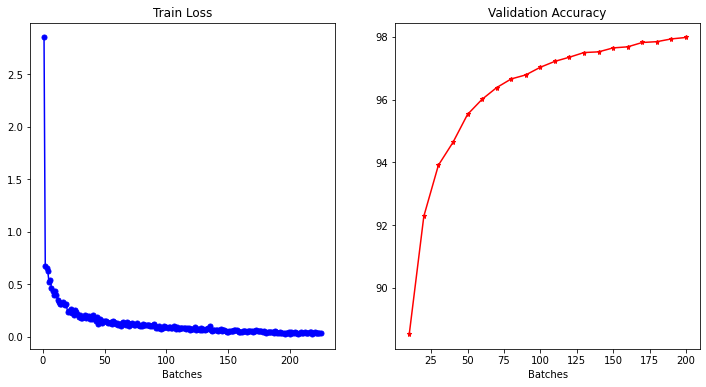

In [ ]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,2 , figsize = (12 , 6))
ax[0].plot(range(1,226,1) , [l.item() for l in Loss_train_rnn],color = 'b',marker = 'o', ms = 5)
ax[0].set_title('Train Loss')
ax[0].set_xlabel("Batches")
ax[1].plot(range(10,210 , 10) , Acc_valid_rnn , color = 'r' , marker = '*' , ms = 5)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel("Batches");

## Tunning Hyperparameters(Embedding Size , Number Of Layers , Hidden Size )

In [ ]:
EMB = [50 ,100 ,150 ,300]
NL = [1 , 2 , 3]
HS = [64 ,128 ,512]
###
Loss_train_hyp = np.zeros((4 , 3 , 3))
Acc_valid_hyp = np.zeros((4 , 3 , 3))
for emb in EMB:
  for nl in NL:
    for hs in HS:
      print(f"########### Embedding = {emb} , Number of Layers = {nl} , Hidden_size = {hs} ############\n")
      model = RNN(VOCABULARY_SIZE, emb, hs, nl , num_classes).to(device)
      # Loss and optimizer
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      n_total_steps = len(train_loader)
      for epoch in range(num_epochs):
          for i, (inputs, labels) in enumerate(train_loader):  
              # origin shape: [N, 1, 28, 28]
              # resized: [N, 28, 28]
              inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE ).to(device)
              labels = labels.to(device)
              
              # Forward pass
              outputs = model(inputs)
              loss = criterion(outputs.transpose(1,2), labels.transpose(1,2))
              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              
              if (i+1) % 10 == 0:
                  print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
                  # Test the model
                  # In test phase, we don't need to compute gradients (for memory efficiency)
                  with torch.no_grad():
                      n_correct = 0
                      n_samples = 0
                      for inputs, labels in valid_loader:
                          inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE).to(device)
                          labels = labels.to(device)
                          outputs = model(inputs)
                          # max returns (value ,index)
                          #print(outputs.shape)
                          _, predicted = torch.max(outputs, 2)
                          #print(predicted.shape)
                          n_samples += labels.size(0)*labels.size(1)
                          n_correct += (predicted == torch.max(labels,2)[1]).sum().item()
                          #n_correct += (predicted == labels).sum().item()

                      acc = 100.0 * n_correct / n_samples
                      print(f'Accuracy of the network on the valid dataset of length {len(validation_dataset)} : {acc} %')

      Loss_train_hyp[EMB.index(emb) , NL.index(nl) , HS.index(hs)] = loss.item()
      Acc_valid_hyp[EMB.index(emb) , NL.index(nl) , HS.index(hs)] = acc



########### Embedding = 50 , Number of Layers = 1 , Hidden_size = 64############

Epoch [1/5], Step [10/45], Loss: 0.8396
Accuracy of the network on the valid dataset of length 499 : 77.18436873747495 %
Epoch [1/5], Step [20/45], Loss: 0.7481
Accuracy of the network on the valid dataset of length 499 : 79.73547094188376 %
Epoch [1/5], Step [30/45], Loss: 0.6101
Accuracy of the network on the valid dataset of length 499 : 83.33066132264528 %
Epoch [1/5], Step [40/45], Loss: 0.5212
Accuracy of the network on the valid dataset of length 499 : 84.73346693386773 %
Epoch [2/5], Step [10/45], Loss: 0.4791
Accuracy of the network on the valid dataset of length 499 : 86.34869739478958 %
Epoch [2/5], Step [20/45], Loss: 0.4545
Accuracy of the network on the valid dataset of length 499 : 88.03607214428858 %
Epoch [2/5], Step [30/45], Loss: 0.4172
Accuracy of the network on the valid dataset of length 499 : 88.86773547094188 %
Epoch [2/5], Step [40/45], Loss: 0.3772
Accuracy of the network on the 

In [ ]:
np.where(Acc_valid_hyp == np.amax(Acc_valid_hyp)) # embedding => 300 , num_layer=> 2 , Hidden_size = 512

(array([3]), array([1]), array([2]))

## Evaluating diffrent hidden size(Plotting)

In [ ]:
HS = [64 ,128 ,512]
###
Loss_train_hd = []
Acc_valid_hd = []

for hs in HS:
  print(f"########### Hidden_size = {hs} ############\n")
  model = RNN(VOCABULARY_SIZE, 300, hs, 2 , num_classes).to(device)
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      for i, (inputs, labels) in enumerate(train_loader):  
          # origin shape: [N, 1, 28, 28]
          # resized: [N, 28, 28]
          inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE ).to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs.transpose(1,2), labels.transpose(1,2))
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if (i+1) % 10 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
              # Test the model
              # In test phase, we don't need to compute gradients (for memory efficiency)
              Loss_train_hd.append(loss.item())
              with torch.no_grad():
                  n_correct = 0
                  n_samples = 0
                  for inputs, labels in valid_loader:
                      inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE).to(device)
                      labels = labels.to(device)
                      outputs = model(inputs)
                      # max returns (value ,index)
                      #print(outputs.shape)
                      _, predicted = torch.max(outputs, 2)
                      #print(predicted.shape)
                      n_samples += labels.size(0)*labels.size(1)
                      n_correct += (predicted == torch.max(labels,2)[1]).sum().item()
                      #n_correct += (predicted == labels).sum().item()

                  acc = 100.0 * n_correct / n_samples
                  Acc_valid_hd.append(acc)
                  print(f'Accuracy of the network on the valid dataset of length {len(validation_dataset)} : {acc} %')

  

########### Hidden_size = 64 ############

Epoch [1/5], Step [10/45], Loss: 0.6882
Accuracy of the network on the valid dataset of length 499 : 79.50300601202404 %
Epoch [1/5], Step [20/45], Loss: 0.5920
Accuracy of the network on the valid dataset of length 499 : 84.43687374749499 %
Epoch [1/5], Step [30/45], Loss: 0.5304
Accuracy of the network on the valid dataset of length 499 : 87.92384769539078 %
Epoch [1/5], Step [40/45], Loss: 0.4246
Accuracy of the network on the valid dataset of length 499 : 89.29058116232466 %
Epoch [2/5], Step [10/45], Loss: 0.3707
Accuracy of the network on the valid dataset of length 499 : 91.61122244488978 %
Epoch [2/5], Step [20/45], Loss: 0.3505
Accuracy of the network on the valid dataset of length 499 : 92.43486973947896 %
Epoch [2/5], Step [30/45], Loss: 0.2628
Accuracy of the network on the valid dataset of length 499 : 93.26653306613227 %
Epoch [2/5], Step [40/45], Loss: 0.2284
Accuracy of the network on the valid dataset of length 499 : 94.020040

Text(0, 0.5, 'Accuracy')

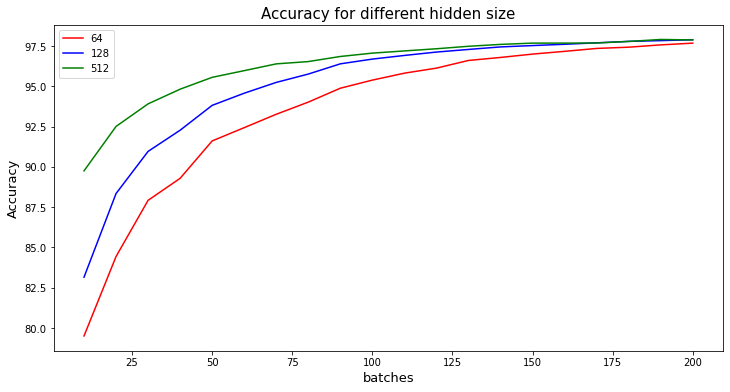

In [ ]:
import matplotlib.pyplot as plt
C = ['r' , 'b' , 'g']
plt.figure(figsize = (12,6))
for i in range(3):
  plt.plot(range(10,210,10) , Acc_valid_hd[20*i:20+20*i] , color = C[i])
plt.legend(HS)
plt.title("Accuracy for different hidden size",size = 15)
plt.xlabel("batches", size = 13)
plt.ylabel("Accuracy", size = 13)

# **GRN Language Model**

In [ ]:
# RNN based language model
class GRU(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers , num_classes):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size,  num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Embed word ids to vectors
        x = self.embed(x)
        #print(x.shape)
        # Forward propagate LSTM
        out, _ = self.gru(x, h0) 
        #print(out.shape)
        # Reshape output to (batch_size*sequence_length, hidden_size)
        #out = out[:, -1, :]
        #print(out.shape)
        # Decode hidden states of all time steps
        out = self.fc(out)
        #print(out.shape)
        return out

model = GRU(VOCABULARY_SIZE, EMBEDDING_SIZE, hidden_size, num_layers , num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
(inputs, labels) = next(iter(train_loader))
model(inputs.to(device).long())

tensor([[[-0.2409,  0.0630, -0.1956,  ...,  0.0364, -0.1200,  0.1203],
         [-0.3113,  0.0764, -0.2785,  ...,  0.0500, -0.1505,  0.2001],
         [-0.3299,  0.0679, -0.3236,  ...,  0.0477, -0.1586,  0.2450],
         ...,
         [ 0.0377, -0.0424,  0.0719,  ..., -0.0343, -0.1851,  0.0833],
         [ 0.0510, -0.2149,  0.0533,  ..., -0.0111, -0.1039, -0.0297],
         [ 0.2238, -0.2122,  0.0023,  ..., -0.0626, -0.2450, -0.1340]],

        [[-0.2409,  0.0630, -0.1956,  ...,  0.0364, -0.1200,  0.1203],
         [-0.3113,  0.0764, -0.2785,  ...,  0.0500, -0.1505,  0.2001],
         [-0.3299,  0.0679, -0.3236,  ...,  0.0477, -0.1586,  0.2450],
         ...,
         [ 0.0896,  0.1022, -0.1604,  ...,  0.2430,  0.1930,  0.0516],
         [ 0.0876, -0.0977,  0.0097,  ...,  0.0733, -0.1303, -0.0655],
         [ 0.2307, -0.1662, -0.0117,  ..., -0.0261, -0.1775, -0.1607]],

        [[-0.2409,  0.0630, -0.1956,  ...,  0.0364, -0.1200,  0.1203],
         [-0.3113,  0.0764, -0.2785,  ...,  0

## Train the model

In [ ]:
Loss_train_gru = []
Acc_valid_gru = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE ).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.transpose(1,2), labels.transpose(1,2))
        Loss_train_gru.append(loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        # Test the model
        # In test phase, we don't need to compute gradients (for memory efficiency)
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for inputs, labels in valid_loader:
                    inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE).to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    # max returns (value ,index)
                    #print(outputs.shape)
                    _, predicted = torch.max(outputs, 2)
                    #print(predicted.shape)
                    n_samples += labels.size(0)*labels.size(1)
                    n_correct += (predicted == torch.max(labels,2)[1]).sum().item()
                    #n_correct += (predicted == labels).sum().item()

                acc = 100.0 * n_correct / n_samples
                Acc_valid_gru.append(acc)
                print(f'Accuracy of the network on the valid dataset of length {len(validation_dataset)} : {acc} %')

Epoch [1/5], Step [10/45], Loss: 0.3846
Accuracy of the network on the valid dataset of length 499 : 88.24849699398797 %
Epoch [1/5], Step [20/45], Loss: 0.2828
Accuracy of the network on the valid dataset of length 499 : 92.27655310621242 %
Epoch [1/5], Step [30/45], Loss: 0.2344
Accuracy of the network on the valid dataset of length 499 : 94.16432865731463 %
Epoch [1/5], Step [40/45], Loss: 0.1770
Accuracy of the network on the valid dataset of length 499 : 95.11222444889779 %
Epoch [2/5], Step [10/45], Loss: 0.1322
Accuracy of the network on the valid dataset of length 499 : 96.19238476953907 %
Epoch [2/5], Step [20/45], Loss: 0.1142
Accuracy of the network on the valid dataset of length 499 : 96.61723446893788 %
Epoch [2/5], Step [30/45], Loss: 0.1086
Accuracy of the network on the valid dataset of length 499 : 96.97595190380761 %
Epoch [2/5], Step [40/45], Loss: 0.0767
Accuracy of the network on the valid dataset of length 499 : 97.1062124248497 %
Epoch [3/5], Step [10/45], Loss: 

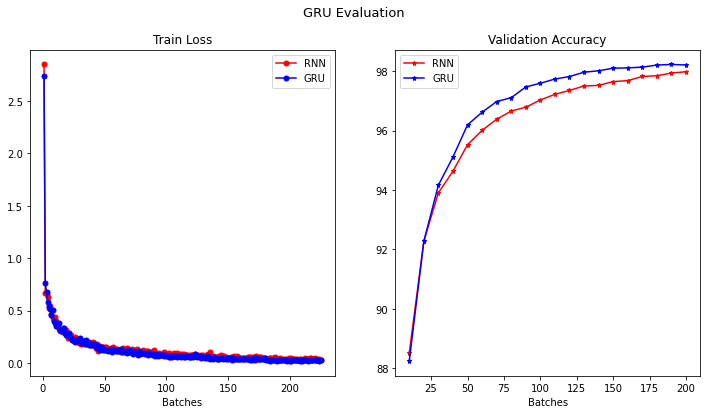

In [ ]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,2 , figsize = (12 , 6))
ax[0].plot(range(1,226,1) , [l.item() for l in Loss_train_rnn],color = 'r',marker = 'o', ms = 5)
ax[0].plot(range(1,226,1) , [l.item() for l in Loss_train_gru],color = 'b',marker = 'o', ms = 5)
ax[0].set_title('Train Loss')
ax[0].set_xlabel("Batches")
ax[0].legend(["RNN" , "GRU"])
ax[1].plot(range(10,210 , 10) , Acc_valid_rnn , color = 'r' , marker = '*' , ms = 5)
ax[1].plot(range(10,210 , 10) , Acc_valid_gru , color = 'b' , marker = '*' , ms = 5)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel("Batches")
ax[1].legend(["RNN" , "GRU"])
fig.suptitle("GRU Evaluation", size = 13);

## Tunning Hyperparameters(Embedding Size , Number Of Layers , Hidden Size )

In [ ]:
EMB = [50 ,100 ,150 ,300]
NL = [1 , 2 , 3]
HS = [64 ,128 ,512]
###
Loss_train_hyp = np.zeros((4 , 3 , 3))
Acc_valid_hyp = np.zeros((4 , 3 , 3))
for emb in EMB:
  for nl in NL:
    for hs in HS:
      print(f"########### Embedding = {emb} , Number of Layers = {nl} , Hidden_size = {hs}############\n")
      model = GRU(VOCABULARY_SIZE, emb, hs, nl , num_classes).to(device)
      # Loss and optimizer
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      n_total_steps = len(train_loader)
      for epoch in range(num_epochs):
          for i, (inputs, labels) in enumerate(train_loader):  
              # origin shape: [N, 1, 28, 28]
              # resized: [N, 28, 28]
              inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE ).to(device)
              labels = labels.to(device)
              
              # Forward pass
              outputs = model(inputs)
              loss = criterion(outputs.transpose(1,2), labels.transpose(1,2))
              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              
              if (i+1) % 10 == 0:
                  print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
                  # Test the model
                  # In test phase, we don't need to compute gradients (for memory efficiency)
                  with torch.no_grad():
                      n_correct = 0
                      n_samples = 0
                      for inputs, labels in valid_loader:
                          inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE).to(device)
                          labels = labels.to(device)
                          outputs = model(inputs)
                          # max returns (value ,index)
                          #print(outputs.shape)
                          _, predicted = torch.max(outputs, 2)
                          #print(predicted.shape)
                          n_samples += labels.size(0)*labels.size(1)
                          n_correct += (predicted == torch.max(labels,2)[1]).sum().item()
                          #n_correct += (predicted == labels).sum().item()

                      acc = 100.0 * n_correct / n_samples
                      print(f'Accuracy of the network on the valid dataset of length {len(validation_dataset)} : {acc} %')

      Loss_train_hyp[EMB.index(emb) , NL.index(nl) , HS.index(hs)] = loss.item()
      Acc_valid_hyp[EMB.index(emb) , NL.index(nl) , HS.index(hs)] = acc



########### Embedding = 50 , Number of Layers = 1 , Hidden_size = 64############

Epoch [1/5], Step [10/45], Loss: 0.8473
Accuracy of the network on the valid dataset of length 499 : 77.3627254509018 %
Epoch [1/5], Step [20/45], Loss: 0.6116
Accuracy of the network on the valid dataset of length 499 : 78.66533066132264 %
Epoch [1/5], Step [30/45], Loss: 0.6642
Accuracy of the network on the valid dataset of length 499 : 81.18436873747495 %
Epoch [1/5], Step [40/45], Loss: 0.5528
Accuracy of the network on the valid dataset of length 499 : 83.86973947895791 %
Epoch [2/5], Step [10/45], Loss: 0.4962
Accuracy of the network on the valid dataset of length 499 : 85.81963927855712 %
Epoch [2/5], Step [20/45], Loss: 0.4905
Accuracy of the network on the valid dataset of length 499 : 86.687374749499 %
Epoch [2/5], Step [30/45], Loss: 0.4393
Accuracy of the network on the valid dataset of length 499 : 88.1623246492986 %
Epoch [2/5], Step [40/45], Loss: 0.3924
Accuracy of the network on the vali

In [ ]:
np.where(Acc_valid_hyp == np.amax(Acc_valid_hyp)) # embedding => 300 , num_layer=> 1 , Hidden_size = 512

(array([3]), array([0]), array([2]))

In [ ]:
Acc_valid_hyp

array([[[94.82765531, 95.90380762, 96.55310621],
        [94.66533066, 96.24649299, 96.80160321],
        [94.37074148, 95.99799599, 96.47895792]],

       [[96.4749499 , 97.20240481, 97.49699399],
        [96.40280561, 97.21042084, 97.48697395],
        [96.26853707, 97.16833667, 97.43286573]],

       [[97.00801603, 97.64128257, 97.86372745],
        [97.13226453, 97.66933868, 97.90781563],
        [96.63126253, 97.63527054, 97.6753507 ]],

       [[97.66933868, 98.00801603, 98.24248497],
        [97.62124248, 98.1002004 , 98.15831663],
        [97.63527054, 97.96793587, 98.01603206]]])

## Evaluating different hidden size(Plotting)

In [ ]:
HS = [64 ,128 ,512]
###
Loss_train_hd_gru = []
Acc_valid_hd_gru = []

for hs in HS:
  print(f"########### Hidden_size = {hs} ############\n")
  model = GRU(VOCABULARY_SIZE, 300, hs, 2 , num_classes).to(device)
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      for i, (inputs, labels) in enumerate(train_loader):  
          # origin shape: [N, 1, 28, 28]
          # resized: [N, 28, 28]
          inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE ).to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs.transpose(1,2), labels.transpose(1,2))
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if (i+1) % 10 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
              # Test the model
              # In test phase, we don't need to compute gradients (for memory efficiency)
              Loss_train_hd_gru.append(loss.item())
              with torch.no_grad():
                  n_correct = 0
                  n_samples = 0
                  for inputs, labels in valid_loader:
                      inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE).to(device)
                      labels = labels.to(device)
                      outputs = model(inputs)
                      # max returns (value ,index)
                      #print(outputs.shape)
                      _, predicted = torch.max(outputs, 2)
                      #print(predicted.shape)
                      n_samples += labels.size(0)*labels.size(1)
                      n_correct += (predicted == torch.max(labels,2)[1]).sum().item()
                      #n_correct += (predicted == labels).sum().item()

                  acc = 100.0 * n_correct / n_samples
                  Acc_valid_hd_gru.append(acc)
                  print(f'Accuracy of the network on the valid dataset of length {len(validation_dataset)} : {acc} %')

  
  



########### Hidden_size = 64 ############

Epoch [1/5], Step [10/45], Loss: 0.7149
Accuracy of the network on the valid dataset of length 499 : 79.00400801603206 %
Epoch [1/5], Step [20/45], Loss: 0.5962
Accuracy of the network on the valid dataset of length 499 : 82.46092184368737 %
Epoch [1/5], Step [30/45], Loss: 0.5476
Accuracy of the network on the valid dataset of length 499 : 84.5370741482966 %
Epoch [1/5], Step [40/45], Loss: 0.4641
Accuracy of the network on the valid dataset of length 499 : 85.88577154308618 %
Epoch [2/5], Step [10/45], Loss: 0.3927
Accuracy of the network on the valid dataset of length 499 : 88.31062124248497 %
Epoch [2/5], Step [20/45], Loss: 0.3532
Accuracy of the network on the valid dataset of length 499 : 91.07214428857715 %
Epoch [2/5], Step [30/45], Loss: 0.2854
Accuracy of the network on the valid dataset of length 499 : 92.49298597194388 %
Epoch [2/5], Step [40/45], Loss: 0.2998
Accuracy of the network on the valid dataset of length 499 : 93.3386773

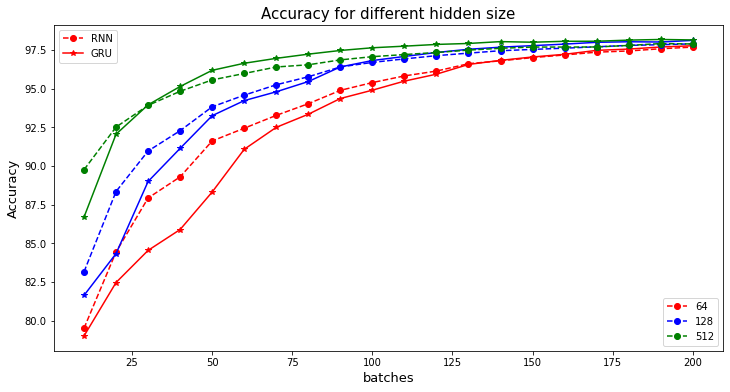

In [ ]:
import matplotlib.pyplot as plt
C = ['r' , 'b' , 'g']
plt.figure(figsize = (12,6))
plot_lines = []
for i in range(3):
  l1, = plt.plot(range(10,210,10) , Acc_valid_hd[20*i:20+20*i] , color = C[i] , marker = 'o' , ls = '--')
  l2, = plt.plot(range(10,210,10) , Acc_valid_hd_gru[20*i:20+20*i] , color = C[i] , marker = '*')
  plot_lines.append([l1, l2])

plt.title("Accuracy for different hidden size",size = 15)
plt.xlabel("batches", size = 13)
plt.ylabel("Accuracy", size = 13)

legend1 = plt.legend(plot_lines[0], ["RNN", "GRU"], loc=0)
plt.legend([l[0] for l in plot_lines], HS , loc=4)
plt.gca().add_artist(legend1);

# **LSTM Language Model**

In [ ]:
# RNN based language model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers , num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size,  num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # Embed word ids to vectors
        x = self.embed(x)
        #print(x.shape)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0,c0))  
        #print(out.shape)
        # Reshape output to (batch_size*sequence_length, hidden_size)
        #out = out[:, -1, :]
        #print(out.shape)
        # Decode hidden states of all time steps
        out = self.fc(out)
        #print(out.shape)
        return out

model = GRU(VOCABULARY_SIZE, EMBEDDING_SIZE, hidden_size, num_layers , num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
(inputs, labels) = next(iter(train_loader))
model(inputs.to(device).long())

tensor([[[ 0.0912, -0.3002,  0.0681,  ..., -0.1058,  0.0272, -0.0301],
         [ 0.1106, -0.4121,  0.0666,  ..., -0.1440,  0.0305, -0.0415],
         [ 0.1046, -0.4570,  0.0598,  ..., -0.1554,  0.0274, -0.0542],
         ...,
         [-0.1726,  0.0344,  0.1177,  ..., -0.0815,  0.2303, -0.0688],
         [-0.0843, -0.0695,  0.1386,  ..., -0.0285,  0.0056, -0.0311],
         [-0.2147, -0.1179, -0.0354,  ..., -0.0159,  0.0091,  0.0299]],

        [[ 0.0912, -0.3002,  0.0681,  ..., -0.1058,  0.0272, -0.0301],
         [ 0.1106, -0.4121,  0.0666,  ..., -0.1440,  0.0305, -0.0415],
         [ 0.1046, -0.4570,  0.0598,  ..., -0.1554,  0.0274, -0.0542],
         ...,
         [-0.1797,  0.0162,  0.2260,  ..., -0.0391, -0.0622,  0.2100],
         [-0.1455, -0.1395,  0.3200,  ..., -0.0301,  0.0905,  0.3075],
         [-0.2934, -0.1356,  0.0952,  ..., -0.0234,  0.0409,  0.1626]],

        [[ 0.0912, -0.3002,  0.0681,  ..., -0.1058,  0.0272, -0.0301],
         [ 0.1106, -0.4121,  0.0666,  ..., -0

## Train the model

In [ ]:
Loss_train_lstm = []
Acc_valid_lstm = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE ).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.transpose(1,2), labels.transpose(1,2))
        Loss_train_lstm.append(loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        # Test the model
        # In test phase, we don't need to compute gradients (for memory efficiency)
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for inputs, labels in valid_loader:
                    inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE).to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    # max returns (value ,index)
                    #print(outputs.shape)
                    _, predicted = torch.max(outputs, 2)
                    #print(predicted.shape)
                    n_samples += labels.size(0)*labels.size(1)
                    n_correct += (predicted == torch.max(labels,2)[1]).sum().item()
                    #n_correct += (predicted == labels).sum().item()

                acc = 100.0 * n_correct / n_samples
                Acc_valid_lstm.append(acc)
                print(f'Accuracy of the network on the valid dataset of length {len(validation_dataset)} : {acc} %')

Epoch [1/5], Step [10/45], Loss: 0.4213
Accuracy of the network on the valid dataset of length 499 : 88.09218436873748 %
Epoch [1/5], Step [20/45], Loss: 0.2811
Accuracy of the network on the valid dataset of length 499 : 92.02605210420842 %
Epoch [1/5], Step [30/45], Loss: 0.2331
Accuracy of the network on the valid dataset of length 499 : 93.88977955911824 %
Epoch [1/5], Step [40/45], Loss: 0.1949
Accuracy of the network on the valid dataset of length 499 : 94.97194388777555 %
Epoch [2/5], Step [10/45], Loss: 0.1401
Accuracy of the network on the valid dataset of length 499 : 95.95190380761522 %
Epoch [2/5], Step [20/45], Loss: 0.1288
Accuracy of the network on the valid dataset of length 499 : 96.37675350701403 %
Epoch [2/5], Step [30/45], Loss: 0.1063
Accuracy of the network on the valid dataset of length 499 : 96.80160320641282 %
Epoch [2/5], Step [40/45], Loss: 0.0935
Accuracy of the network on the valid dataset of length 499 : 97.0440881763527 %
Epoch [3/5], Step [10/45], Loss: 

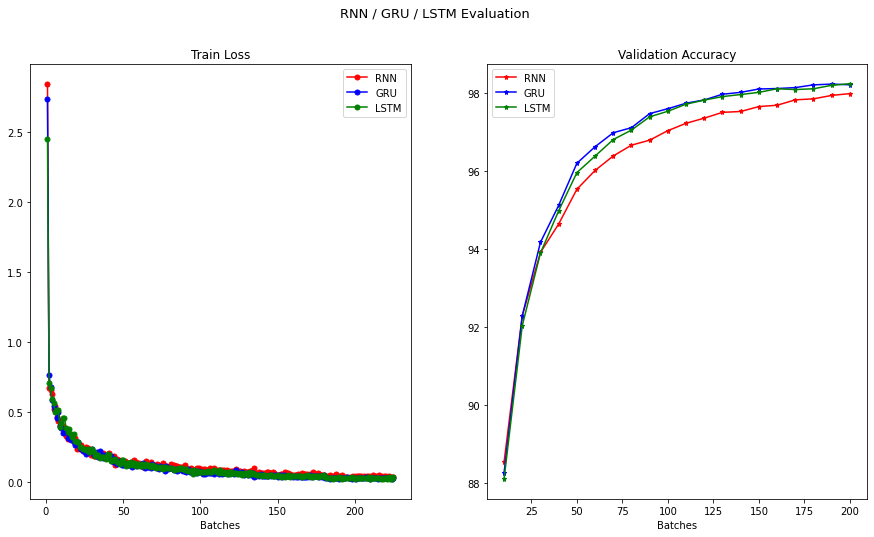

In [ ]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,2 , figsize = (15 , 8))
ax[0].plot(range(1,226,1) , [l.item() for l in Loss_train_rnn],color = 'r',marker = 'o', ms = 5)
ax[0].plot(range(1,226,1) , [l.item() for l in Loss_train_gru],color = 'b',marker = 'o', ms = 5)
ax[0].plot(range(1,226,1) , [l.item() for l in Loss_train_lstm],color = 'g',marker = 'o', ms = 5)
ax[0].set_title('Train Loss')
ax[0].set_xlabel("Batches")
ax[0].legend(["RNN" , "GRU" , "LSTM"])
ax[1].plot(range(10,210 , 10) , Acc_valid_rnn , color = 'r' , marker = '*' , ms = 5)
ax[1].plot(range(10,210 , 10) , Acc_valid_gru , color = 'b' , marker = '*' , ms = 5)
ax[1].plot(range(10,210 , 10) , Acc_valid_lstm , color = 'g' , marker = '*' , ms = 5)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel("Batches")
ax[1].legend(["RNN" , "GRU" , "LSTM"])
fig.suptitle("RNN / GRU / LSTM Evaluation", size = 13);

## Tunning Hyperparameters(Embedding Size , Number Of Layers , Hidden Size )

In [ ]:
EMB = [50 ,100 ,150 ,300]
NL = [1 , 2 , 3]
HS = [64 ,128 ,512]
###
Loss_train_hyp = np.zeros((4 , 3 , 3))
Acc_valid_hyp = np.zeros((4 , 3 , 3))
for emb in EMB:
  for nl in NL:
    for hs in HS:
      print(f"########### Embedding = {emb} , Number of Layers = {nl} , Hidden_size = {hs}############\n")
      model = LSTM(VOCABULARY_SIZE, emb, hs, nl , num_classes).to(device)
      # Loss and optimizer
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      n_total_steps = len(train_loader)
      for epoch in range(num_epochs):
          for i, (inputs, labels) in enumerate(train_loader):  
              # origin shape: [N, 1, 28, 28]
              # resized: [N, 28, 28]
              inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE ).to(device)
              labels = labels.to(device)
              
              # Forward pass
              outputs = model(inputs)
              loss = criterion(outputs.transpose(1,2), labels.transpose(1,2))
              # Backward and optimize
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              
              if (i+1) % 10 == 0:
                  print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
                  # Test the model
                  # In test phase, we don't need to compute gradients (for memory efficiency)
                  with torch.no_grad():
                      n_correct = 0
                      n_samples = 0
                      for inputs, labels in valid_loader:
                          inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE).to(device)
                          labels = labels.to(device)
                          outputs = model(inputs)
                          # max returns (value ,index)
                          #print(outputs.shape)
                          _, predicted = torch.max(outputs, 2)
                          #print(predicted.shape)
                          n_samples += labels.size(0)*labels.size(1)
                          n_correct += (predicted == torch.max(labels,2)[1]).sum().item()
                          #n_correct += (predicted == labels).sum().item()

                      acc = 100.0 * n_correct / n_samples
                      print(f'Accuracy of the network on the valid dataset of length {len(validation_dataset)} : {acc} %')

      Loss_train_hyp[EMB.index(emb) , NL.index(nl) , HS.index(hs)] = loss.item()
      Acc_valid_hyp[EMB.index(emb) , NL.index(nl) , HS.index(hs)] = acc



########### Embedding = 50 , Number of Layers = 1 , Hidden_size = 64############

Epoch [1/5], Step [10/45], Loss: 1.0513
Accuracy of the network on the valid dataset of length 499 : 76.82364729458918 %
Epoch [1/5], Step [20/45], Loss: 0.7462
Accuracy of the network on the valid dataset of length 499 : 79.28456913827655 %
Epoch [1/5], Step [30/45], Loss: 0.6734
Accuracy of the network on the valid dataset of length 499 : 82.43887775551102 %
Epoch [1/5], Step [40/45], Loss: 0.5562
Accuracy of the network on the valid dataset of length 499 : 84.03006012024048 %
Epoch [2/5], Step [10/45], Loss: 0.4971
Accuracy of the network on the valid dataset of length 499 : 84.30661322645291 %
Epoch [2/5], Step [20/45], Loss: 0.5276
Accuracy of the network on the valid dataset of length 499 : 85.96593186372745 %
Epoch [2/5], Step [30/45], Loss: 0.4363
Accuracy of the network on the valid dataset of length 499 : 86.66733466933867 %
Epoch [2/5], Step [40/45], Loss: 0.4002
Accuracy of the network on the 

In [ ]:
np.where(Acc_valid_hyp == np.amax(Acc_valid_hyp)) # embedding => 300 , num_layer=> 1 , Hidden_size = 512

(array([3]), array([0]), array([2]))

## Evaluating different hidden size(Plotting)

In [ ]:
HS = [64 ,128 ,512]
###
Loss_train_hd_lstm = []
Acc_valid_hd_lstm = []

for hs in HS:
  print(f"########### Hidden_size = {hs} ############\n")
  model = LSTM(VOCABULARY_SIZE, 300, hs, 2 , num_classes).to(device)
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      for i, (inputs, labels) in enumerate(train_loader):  
          # origin shape: [N, 1, 28, 28]
          # resized: [N, 28, 28]
          inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE ).to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs.transpose(1,2), labels.transpose(1,2))
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if (i+1) % 10 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
              # Test the model
              # In test phase, we don't need to compute gradients (for memory efficiency)
              Loss_train_hd_lstm.append(loss.item())
              with torch.no_grad():
                  n_correct = 0
                  n_samples = 0
                  for inputs, labels in valid_loader:
                      inputs = inputs.to(device).long()#.reshape(-1, MAX_SEQ_LENGTH , EMBEDDING_SIZE).to(device)
                      labels = labels.to(device)
                      outputs = model(inputs)
                      # max returns (value ,index)
                      #print(outputs.shape)
                      _, predicted = torch.max(outputs, 2)
                      #print(predicted.shape)
                      n_samples += labels.size(0)*labels.size(1)
                      n_correct += (predicted == torch.max(labels,2)[1]).sum().item()
                      #n_correct += (predicted == labels).sum().item()

                  acc = 100.0 * n_correct / n_samples
                  Acc_valid_hd_lstm.append(acc)
                  print(f'Accuracy of the network on the valid dataset of length {len(validation_dataset)} : {acc} %')

  
  



########### Hidden_size = 64 ############

Epoch [1/5], Step [10/45], Loss: 0.9418
Accuracy of the network on the valid dataset of length 499 : 76.47695390781563 %
Epoch [1/5], Step [20/45], Loss: 0.7996
Accuracy of the network on the valid dataset of length 499 : 79.53507014028057 %
Epoch [1/5], Step [30/45], Loss: 0.6453
Accuracy of the network on the valid dataset of length 499 : 81.51302605210421 %
Epoch [1/5], Step [40/45], Loss: 0.5829
Accuracy of the network on the valid dataset of length 499 : 82.03807615230461 %
Epoch [2/5], Step [10/45], Loss: 0.5325
Accuracy of the network on the valid dataset of length 499 : 82.8376753507014 %
Epoch [2/5], Step [20/45], Loss: 0.5204
Accuracy of the network on the valid dataset of length 499 : 83.47895791583166 %
Epoch [2/5], Step [30/45], Loss: 0.4455
Accuracy of the network on the valid dataset of length 499 : 85.64529058116233 %
Epoch [2/5], Step [40/45], Loss: 0.4343
Accuracy of the network on the valid dataset of length 499 : 88.3286573

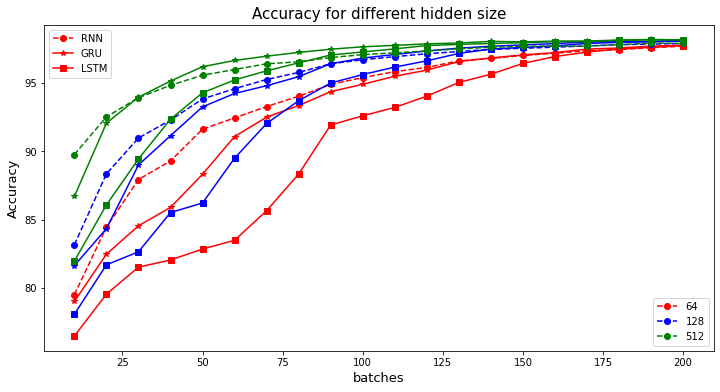

In [ ]:
import matplotlib.pyplot as plt
C = ['r' , 'b' , 'g']
plt.figure(figsize = (12,6))
plot_lines = []
for i in range(3):
  l1, = plt.plot(range(10,210,10) , Acc_valid_hd[20*i:20+20*i] , color = C[i] , marker = 'o' , ls = '--')
  l2, = plt.plot(range(10,210,10) , Acc_valid_hd_gru[20*i:20+20*i] , color = C[i] , marker = '*' )
  l3, = plt.plot(range(10,210,10) , Acc_valid_hd_lstm[20*i:20+20*i] , color = C[i] , marker = 's')
  plot_lines.append([l1, l2 , l3])

plt.title("Accuracy for different hidden size",size = 15)
plt.xlabel("batches", size = 13)
plt.ylabel("Accuracy", size = 13)

legend1 = plt.legend(plot_lines[0], ["RNN", "GRU" , "LSTM"], loc=0)
plt.legend([l[0] for l in plot_lines], HS , loc=4)
plt.gca().add_artist(legend1);